In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

Возьмем готовый претренированный ResNet50

In [6]:
transfer_model = models.resnet50(pretrained=True)

Фризим слои, которые мы не хотим обновлять в дообучении. Для этого мы не даем накапливаться градиентам спмощью requires_grad() для всех параметров сети (доступны через метод paraneters())

Кроме того, не будем фризить блоки BatchNorm чтобьы не терять данные на нормализации

In [7]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

Заменим последний классификационный блок своим хвостом. В данном случае двумя линейными слоями, релу и дропаутом. Пайторч хранит последний блок как переменную экземпляра, поэтому ее можно переопределить.

Переменная in_features позволяет захватывать несколько активаций, входящих в слой. Аналог для исходящих out_features. Они используются в случае, когда вход следующего слоя ожидает от выхода предыдущего одну размерность, а получает другую, что вызывает ошибку.

In [8]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500), 
                                  nn.ReLU(), 
                                  nn.Dropout(), 
                                  nn.Linear(500, 2))

## Обучение

In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [10]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "pytorch_learning/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=img_transforms, 
                                              is_valid_file=check_image)
val_data_path = "pytorch_learning/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=img_transforms, 
                                            is_valid_file=check_image)
# не используем
test_data_path = "pytorch_learning/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path, 
                                             transform=img_transforms, 
                                             is_valid_file=check_image)

batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, 
                                                batch_size=batch_size,
                                                shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [11]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [12]:
train(transfer_model, 
      optimizer,
      torch.nn.CrossEntropyLoss(), 
      train_data_loader,
      val_data_loader, 
      epochs=10, 
      device=device)

Epoch: 0, Training Loss: 0.61, Validation Loss: 0.20, accuracy = 0.91
Epoch: 1, Training Loss: 0.30, Validation Loss: 0.21, accuracy = 0.90
Epoch: 2, Training Loss: 0.12, Validation Loss: 0.18, accuracy = 0.88
Epoch: 3, Training Loss: 0.04, Validation Loss: 0.25, accuracy = 0.91
Epoch: 4, Training Loss: 0.03, Validation Loss: 0.21, accuracy = 0.91
Epoch: 5, Training Loss: 0.01, Validation Loss: 0.31, accuracy = 0.92
Epoch: 6, Training Loss: 0.00, Validation Loss: 0.23, accuracy = 0.93
Epoch: 7, Training Loss: 0.01, Validation Loss: 0.23, accuracy = 0.93
Epoch: 8, Training Loss: 0.00, Validation Loss: 0.22, accuracy = 0.93
Epoch: 9, Training Loss: 0.00, Validation Loss: 0.20, accuracy = 0.92


In [15]:
labels = ['cat','fish']
def predictor(image_for_predict):
    img = Image.open(image_for_predict) 
    img = img_transforms(img).to(device)
    # сеть ожидает 4d тензор, т.к. используются пакеты 
    # (первое значение в тензоре - число изображений в пакете)
    # т.к. у нас пакетов нет, создаем пакет длиной 1 с помощью unsqueeze(0)
    # который добавляет новую размерность в начало тензора
    img = img.unsqueeze(0)

    prediction = F.softmax(transfer_model(img), dim=1)
    prediction = prediction.argmax()
    print(labels[prediction])

In [16]:
# cat
predictor("pytorch_learning/test/cat/2041806579_e4a7f31b32.jpg")

cat


In [17]:
# fish
predictor("pytorch_learning/test/fish/1609947018_bfa1fcd6b2.jpg")

fish


In [18]:
# fish
predictor("pytorch_learning/test/fish/2869804396_c4127ccec6.jpg")

fish


## Вычисление скорости обучения

Метод описан [тут](https://arxiv.org/abs/1506.01186) и предполагает, что в течении эпохи, скорость обучения начинается с небольшой, увеличивается с каждым минибачем, в итоге получается высокая в конце эпохи. Задача заключается в нахождении отношения скорости к потерям и затем в выборе такого показателя скорости, при котором происходит наибольшее снижение потерь (это можно сделать например визуально по графику)

In [19]:
# упрощенный пример реализации метода в open.ai
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

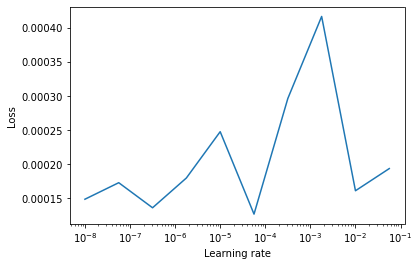

In [20]:
(lrs, losses) = find_lr(transfer_model, 
                        torch.nn.CrossEntropyLoss(),
                        optimizer, 
                        train_data_loader,
                        device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

**Функция фактически обучает модель и связана с настройками оптимизатора. Поэтому необходимо предварительно сохранить и перегрузить модель, чтобы вернуться в состояние, в котором она находилась до вызова find_lr(). Кроме того придется повторно инициализировать оптимизатор.**

## Дифференциальная скорость обучения